# Labs Access Analysis: 06 Population Analysis with Facebook Data - No overlaps between isochrones

## Setup

In [91]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import os
import gc
from matplotlib.patches import Patch

# Change the font
sns.set_context("poster", font_scale=1.5)
sns.set_style(style="whitegrid")
matplotlib.rc('font', family='serif', serif='Fira Sans')

In [2]:
# Load data, csv
data_csv = pd.read_csv('data/valid_labs.csv')
data_csv['Lat'] = data_csv['Lat'].astype(float)
data_csv['Long'] = data_csv['Long'].astype(float)
data_csv = data_csv[(((~data_csv.Lat.isnull()) & (~data_csv.Long.isnull())))]

In [3]:
data_labs = gpd.GeoDataFrame(
    data_csv,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(data_csv.Long, data_csv.Lat))

In [4]:
data_labs.head()

,Unnamed: 0,Name,Type,City,Cluster,Address,CAP,Lat,Long,Source,URL,Notes,geometry
0,0,Fab Lab Barcelona,Fab Lab,Barcelona,BCN,"Carrer de Pujades, 102",8005.0,41.396925,2.194335,Fablabs.io,https://fablabbcn.org/,NaN,POINT (2.19434 41.39692)
1,1,MADE Makerspace Barcelona,Fab Lab,Barcelona,BCN,Carrer Noguera Pallaresa 59-61,8014.0,41.373238,2.141084,"Fablabs.io, Hackerspaces.org, Makerspaces.make.co",NaN,NaN,POINT (2.14108 41.37324)
2,2,Soko Tech,Fab Lab,Barcelona,BCN,"Carrer de Vallès i Ribot, 36",8027.0,41.424535,2.188883,Fablabs.io,https://soko.tech/,NaN,POINT (2.18888 41.42454)
3,3,LSCongres,Fab Lab,Barcelona,BCN,"Carrer del Cardenal Tedeschini, 50",8027.0,41.426002,2.182026,Fablabs.io,https://fablabs.io/labs/lscongres,NaN,POINT (2.18203 41.42600)
4,4,Green Fab Lab,Fab Lab,Cerdanyola del Vallès,BCN,"Ctra. BV-1415 (Horta-Cerdanyola), km 7",8290.0,41.450394,2.133441,Fablabs.io,NaN,NaN,POINT (2.13344 41.45039)


In [5]:
data_labs.set_index('Unnamed: 0', inplace=True)
data_labs.index.names = ['']

In [6]:
data_labs.explore()

In [7]:
isochrones = pd.read_json("data/isochrones.json")

In [8]:
isochrones.head()

,type,bbox,features,metadata,name
0,FeatureCollection,"[2.181516, 41.386679, 2.206919, 41.408053]","[{'type': 'Feature', 'properties': {'group_ind...",{'attribution': 'openrouteservice.org | OpenSt...,Fab Lab Barcelona
1,FeatureCollection,"[2.127469, 41.362337, 2.15604, 41.384602]","[{'type': 'Feature', 'properties': {'group_ind...",{'attribution': 'openrouteservice.org | OpenSt...,MADE Makerspace Barcelona
2,FeatureCollection,"[2.174851, 41.412242, 2.201936, 41.435773]","[{'type': 'Feature', 'properties': {'group_ind...",{'attribution': 'openrouteservice.org | OpenSt...,Soko Tech
3,FeatureCollection,"[2.167014, 41.414324, 2.195414, 41.437322]","[{'type': 'Feature', 'properties': {'group_ind...",{'attribution': 'openrouteservice.org | OpenSt...,LSCongres
4,FeatureCollection,"[2.126857, 41.443694, 2.14223, 41.454446]","[{'type': 'Feature', 'properties': {'group_ind...",{'attribution': 'openrouteservice.org | OpenSt...,Green Fab Lab


## Transform data for geodataframe

In [9]:
isochrones['longitude'] = isochrones['metadata'].apply(lambda x: x['query']['locations'][0][0])
isochrones['latitude'] = isochrones['metadata'].apply(lambda x: x['query']['locations'][0][1])
isochrones['area_units'] = isochrones['metadata'].apply(lambda x: x['query']['area_units'])

In [10]:
isochrones['total_pop'] = isochrones['features'].apply(lambda x: x[0]['properties']['total_pop'])
isochrones['area'] = isochrones['features'].apply(lambda x:x[0]['properties']['area'])
isochrones['reachfactor'] = isochrones['features'].apply(lambda x: x[0]['properties']['reachfactor'])

In [11]:
isochrones['coordinates'] = isochrones['features'].apply(lambda x: x[0]['geometry']['coordinates'])
isochrones['geometry_type'] = isochrones['features'].apply(lambda x: x[0]['geometry']['type'])

In [12]:
isochrones['geometry'] = isochrones['coordinates'].apply(lambda x: Polygon(x[0]))

In [13]:
isochrones = isochrones[['name','longitude','latitude','total_pop','area','reachfactor','geometry']]

In [14]:
isochrones = gpd.GeoDataFrame(
    isochrones,
    geometry=isochrones.geometry,
    crs='EPSG:4326')

In [15]:
isochrones.explore()

In [16]:
isochrones.head()

,name,longitude,latitude,total_pop,area,reachfactor,geometry
0,Fab Lab Barcelona,2.194335,41.396925,90862.0,4444783.82,0.9055,"POLYGON ((2.18152 41.39531, 2.18197 41.39116, ..."
1,MADE Makerspace Barcelona,2.141084,41.373238,87403.0,4378946.71,0.8921,"POLYGON ((2.12747 41.37483, 2.12856 41.36899, ..."
2,Soko Tech,2.188883,41.424535,91433.0,4353937.57,0.8870,"POLYGON ((2.17485 41.42471, 2.17489 41.42377, ..."
3,LSCongres,2.182026,41.426002,95371.0,4497971.38,0.9163,"POLYGON ((2.16701 41.42773, 2.16735 41.42654, ..."
4,Green Fab Lab,2.133441,41.450394,49.0,845558.02,0.1723,"POLYGON ((2.12686 41.45092, 2.12691 41.45013, ..."


In [17]:
isochrones.to_file("data/lab_isochrones.geojson",driver='GeoJSON')

In [18]:
columns = {
    'name': 'Name'
}
isochrones.rename(columns=columns, inplace=True)

In [19]:
labs = isochrones.merge(data_labs, on="Name")
labs = gpd.GeoDataFrame(labs)

In [20]:
columns = {
    'geometry_x': 'geometry'
}
labs.rename(columns=columns, inplace=True)

In [21]:
labs.head()

,Name,longitude,latitude,total_pop,area,reachfactor,geometry,Type,City,Cluster,Address,CAP,Lat,Long,Source,URL,Notes,geometry_y
0,Fab Lab Barcelona,2.194335,41.396925,90862.0,4444783.82,0.9055,"POLYGON ((2.18152 41.39531, 2.18197 41.39116, ...",Fab Lab,Barcelona,BCN,"Carrer de Pujades, 102",8005.0,41.396925,2.194335,Fablabs.io,https://fablabbcn.org/,NaN,POINT (2.19434 41.39692)
1,MADE Makerspace Barcelona,2.141084,41.373238,87403.0,4378946.71,0.8921,"POLYGON ((2.12747 41.37483, 2.12856 41.36899, ...",Fab Lab,Barcelona,BCN,Carrer Noguera Pallaresa 59-61,8014.0,41.373238,2.141084,"Fablabs.io, Hackerspaces.org, Makerspaces.make.co",NaN,NaN,POINT (2.14108 41.37324)
2,Soko Tech,2.188883,41.424535,91433.0,4353937.57,0.8870,"POLYGON ((2.17485 41.42471, 2.17489 41.42377, ...",Fab Lab,Barcelona,BCN,"Carrer de Vallès i Ribot, 36",8027.0,41.424535,2.188883,Fablabs.io,https://soko.tech/,NaN,POINT (2.18888 41.42454)
3,LSCongres,2.182026,41.426002,95371.0,4497971.38,0.9163,"POLYGON ((2.16701 41.42773, 2.16735 41.42654, ...",Fab Lab,Barcelona,BCN,"Carrer del Cardenal Tedeschini, 50",8027.0,41.426002,2.182026,Fablabs.io,https://fablabs.io/labs/lscongres,NaN,POINT (2.18203 41.42600)
4,Green Fab Lab,2.133441,41.450394,49.0,845558.02,0.1723,"POLYGON ((2.12686 41.45092, 2.12691 41.45013, ...",Fab Lab,Cerdanyola del Vallès,BCN,"Ctra. BV-1415 (Horta-Cerdanyola), km 7",8290.0,41.450394,2.133441,Fablabs.io,NaN,NaN,POINT (2.13344 41.45039)


In [22]:
columns = {
    'Name': 'name',
    'Type': 'type',
    'City': 'city',
    'Cluster':  'cluster',
    'Address': 'address',
    'CAP': 'zipcode',
    'Source': 'source',
    'URL': 'url',
    'Notes': 'notes',
    'geomtry_y': 'geomtry'
}
labs.rename(columns=columns, inplace=True)

In [23]:
#labs.to_file("data/labs_isochrones.geojson",driver='GeoJSON')

# Analysis of Facebook data

## Setup and functions

In [24]:
labs_ita = labs[labs.cluster == "MI"]
labs_esp = labs[labs.cluster == "BCN"]
labs_ita = gpd.GeoDataFrame(labs_ita)
labs_esp = gpd.GeoDataFrame(labs_esp)

<AxesSubplot:>

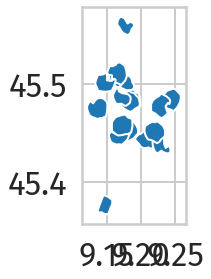

In [25]:
labs_ita.plot()

<AxesSubplot:>

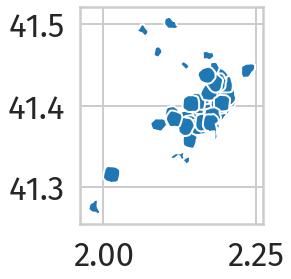

In [26]:
labs_esp.plot()

In [27]:
area_total_ita = labs[labs.cluster == "MI"].dissolve(by='cluster').set_crs(epsg=4326, inplace=True)
area_total_esp = labs[labs.cluster == "BCN"].dissolve(by='cluster').set_crs(epsg=4326, inplace=True)

<AxesSubplot:>

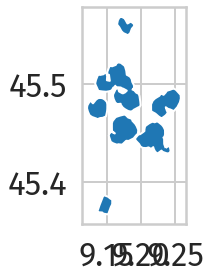

In [28]:
area_total_ita.plot()

<AxesSubplot:>

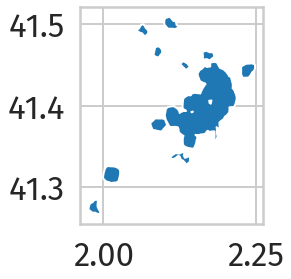

In [29]:
area_total_esp.plot()

In [30]:
area_total_esp

,geometry,name,longitude,latitude,total_pop,area,reachfactor,type,city,address,zipcode,Lat,Long,source,url,notes,geometry_y
cluster,,,,,,,,,,,,,,,,,
BCN,"MULTIPOLYGON (((1.98378 41.28184, 1.98459 41.2...",Fab Lab Barcelona,2.194335,41.396925,90862.0,4444783.82,0.9055,Fab Lab,Barcelona,"Carrer de Pujades, 102",8005.0,41.396925,2.194335,Fablabs.io,https://fablabbcn.org/,NaN,POINT (2.19434 41.39692)


In [31]:
def getgeodataframearea(points,x,y):
    global isochrones
    env = env = isochrones.envelope.unary_union.bounds
    area = points[(points[x] >= env[0]) & (points[x] <= env[2]) & (points[y] >= env[1]) & (points[y] <= env[3])]
    geodataframe = gpd.GeoDataFrame(
        points,
        crs='EPSG:4326',
        geometry=gpd.points_from_xy(points[x], points[y]))
    return geodataframe

In [32]:
def adddatafromfile(data, file, column, datacolumn, coordcolname, tab):
    if tab:
        new_data = pd.read_csv(file, sep='\t')
    else:
        new_data = pd.read_csv(file)
    if coordcolname == "LatLon":
        new_data.rename({'Lon': 'longitude', 'Lat': 'latitude', 'Population': 'population'}, axis=1, inplace=True)
    else:
        new_data.rename({datacolumn: 'population'}, axis=1, inplace=True)
    points_cluster = getgeodataframearea(new_data,x='longitude',y='latitude')
    # save memory - destroy dataframe unused
    # del [[isochrones,ita_population,ita_15_24]]
    del [[new_data]]
    gc.collect()
    isochrones=pd.DataFrame()
    new_data=pd.DataFrame()
    sjoin_lab_points = points_cluster.sjoin(data, how='inner')
    data[column] = data.city.apply(lambda x: round(sjoin_lab_points[sjoin_lab_points.city == x].population.sum()))
    return

## Add data for Italy

In [33]:
adddatafromfile(data=area_total_ita, file="data/hdx/population_ita_2019-07-01.csv", column='total', datacolumn="Population", coordcolname="LatLon", tab=False)

In [34]:
adddatafromfile(data=area_total_ita, file="data/hdx/ITA_men_2019-08-03.csv", column='men', datacolumn="population", coordcolname="LatitudeLongitude", tab=True)

In [35]:
adddatafromfile(data=area_total_ita, file="data/hdx/ITA_women_2019-08-03.csv", column='women', datacolumn="population", coordcolname="LatitudeLongitude", tab=True)

## Add data for Spain

In [36]:
adddatafromfile(data=area_total_esp, file="data/hdx/esp_general_2020.csv", column='total', datacolumn="esp_general_2020", coordcolname="LatitudeLongitude", tab=False)

In [37]:
adddatafromfile(data=area_total_esp, file="data/hdx/esp_men_2020.csv", column='men', datacolumn="esp_men_2020", coordcolname="LatitudeLongitude", tab=False)

In [38]:
adddatafromfile(data=area_total_esp, file="data/hdx/esp_women_2020.csv", column='women', datacolumn="esp_women_2020", coordcolname="LatitudeLongitude", tab=False)

In [39]:
area_total_ita

,geometry,name,longitude,latitude,total_pop,area,reachfactor,type,city,address,zipcode,Lat,Long,source,url,notes,geometry_y,total,men,women
cluster,,,,,,,,,,,,,,,,,,,,
MI,"MULTIPOLYGON (((9.23636 45.43439, 9.24038 45.4...",The FabLab: Make in Milano,9.207913,45.444046,40656.0,3753146.09,0.7646,Fab Lab,Milan,"Via Arcivescovo Calabiana, 6",20139.0,45.444046,9.207913,Fablabs.io,https://www.thefablab.it/,NaN,POINT (9.20791 45.44405),480947,209791,225097


In [40]:
area_total_esp

,geometry,name,longitude,latitude,total_pop,area,reachfactor,type,city,address,zipcode,Lat,Long,source,url,notes,geometry_y,total,men,women
cluster,,,,,,,,,,,,,,,,,,,,
BCN,"MULTIPOLYGON (((1.98378 41.28184, 1.98459 41.2...",Fab Lab Barcelona,2.194335,41.396925,90862.0,4444783.82,0.9055,Fab Lab,Barcelona,"Carrer de Pujades, 102",8005.0,41.396925,2.194335,Fablabs.io,https://fablabbcn.org/,NaN,POINT (2.19434 41.39692),1335063,636049,699014


In [41]:
area_total_ita[["total", "men", "women"]]

,total,men,women
cluster,,,
MI,480947,209791,225097


In [42]:
area_total_esp[["total", "men", "women"]]

,total,men,women
cluster,,,
BCN,1335063,636049,699014


In [43]:
area_total_both = pd.concat([area_total_ita, area_total_esp])

In [44]:
area_total_both

,geometry,name,longitude,latitude,total_pop,area,reachfactor,type,city,address,zipcode,Lat,Long,source,url,notes,geometry_y,total,men,women
cluster,,,,,,,,,,,,,,,,,,,,
MI,"MULTIPOLYGON (((9.23636 45.43439, 9.24038 45.4...",The FabLab: Make in Milano,9.207913,45.444046,40656.0,3753146.09,0.7646,Fab Lab,Milan,"Via Arcivescovo Calabiana, 6",20139.0,45.444046,9.207913,Fablabs.io,https://www.thefablab.it/,NaN,POINT (9.20791 45.44405),480947,209791,225097
BCN,"MULTIPOLYGON (((1.98378 41.28184, 1.98459 41.2...",Fab Lab Barcelona,2.194335,41.396925,90862.0,4444783.82,0.9055,Fab Lab,Barcelona,"Carrer de Pujades, 102",8005.0,41.396925,2.194335,Fablabs.io,https://fablabbcn.org/,NaN,POINT (2.19434 41.39692),1335063,636049,699014


## Plot data

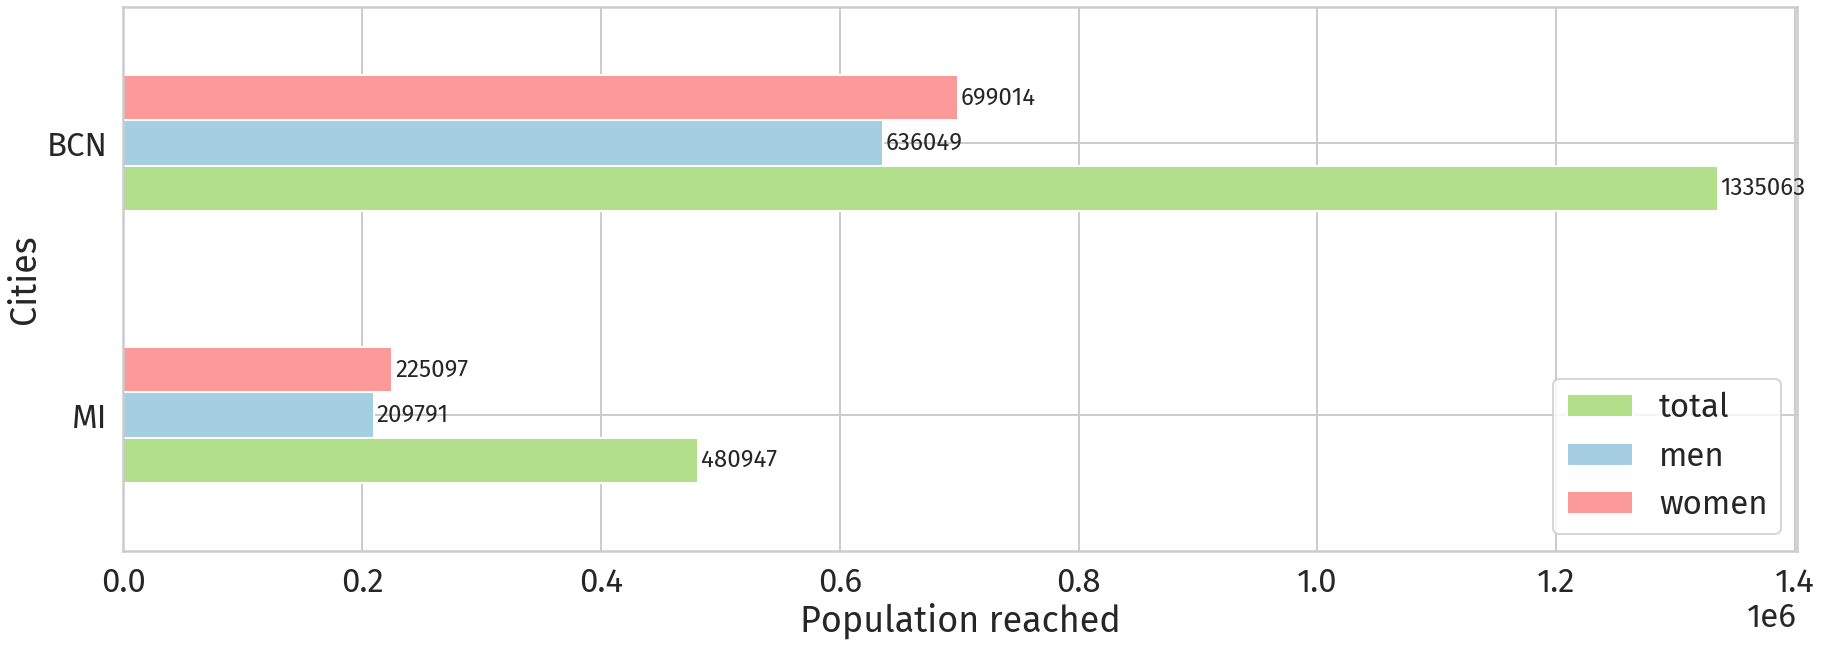

In [45]:
# Plot the data
colors = [sns.color_palette("Paired")[2],sns.color_palette("Paired")[0],sns.color_palette("Paired")[4]]
ax = area_total_both[["total", "men", "women"]].plot(kind="barh", color=colors, figsize=(30,10))
ax.bar_label(ax.containers[0], fmt="%d", size=24, padding=3)
ax.bar_label(ax.containers[1], fmt="%d", size=24, padding=3)
ax.bar_label(ax.containers[2], fmt="%d", size=24, padding=3)
plt.xlabel('Population reached')
plt.ylabel('Cities')
plt.savefig("svg/labs_esp_ita_fbpop_tot.svg", bbox_inches="tight")
plt.savefig("png/labs_esp_ita_fbpop_tot.png", dpi=300, bbox_inches="tight")

## Area

In [46]:
area_total_both["area"]

cluster
MI     3753146.09
BCN    4444783.82
Name: area, dtype: float64

In [47]:
area_total_both.set_crs(epsg=4326, inplace=True)

,geometry,name,longitude,latitude,total_pop,area,reachfactor,type,city,address,zipcode,Lat,Long,source,url,notes,geometry_y,total,men,women
cluster,,,,,,,,,,,,,,,,,,,,
MI,"MULTIPOLYGON (((9.23636 45.43439, 9.24038 45.4...",The FabLab: Make in Milano,9.207913,45.444046,40656.0,3753146.09,0.7646,Fab Lab,Milan,"Via Arcivescovo Calabiana, 6",20139.0,45.444046,9.207913,Fablabs.io,https://www.thefablab.it/,NaN,POINT (9.20791 45.44405),480947,209791,225097
BCN,"MULTIPOLYGON (((1.98378 41.28184, 1.98459 41.2...",Fab Lab Barcelona,2.194335,41.396925,90862.0,4444783.82,0.9055,Fab Lab,Barcelona,"Carrer de Pujades, 102",8005.0,41.396925,2.194335,Fablabs.io,https://fablabbcn.org/,NaN,POINT (2.19434 41.39692),1335063,636049,699014


In [48]:
area_total_both.explore()

In [49]:
area_total_both.to_crs(epsg=3857).geometry.area

cluster
MI     9.669843e+07
BCN    1.426962e+08
dtype: float64

In [50]:
# In square kilomenters km2
area_total_square_km = area_total_both.to_crs(epsg=3857).geometry.area / 1000000.0

In [51]:
area_total_square_km

cluster
MI      96.698435
BCN    142.696195
dtype: float64

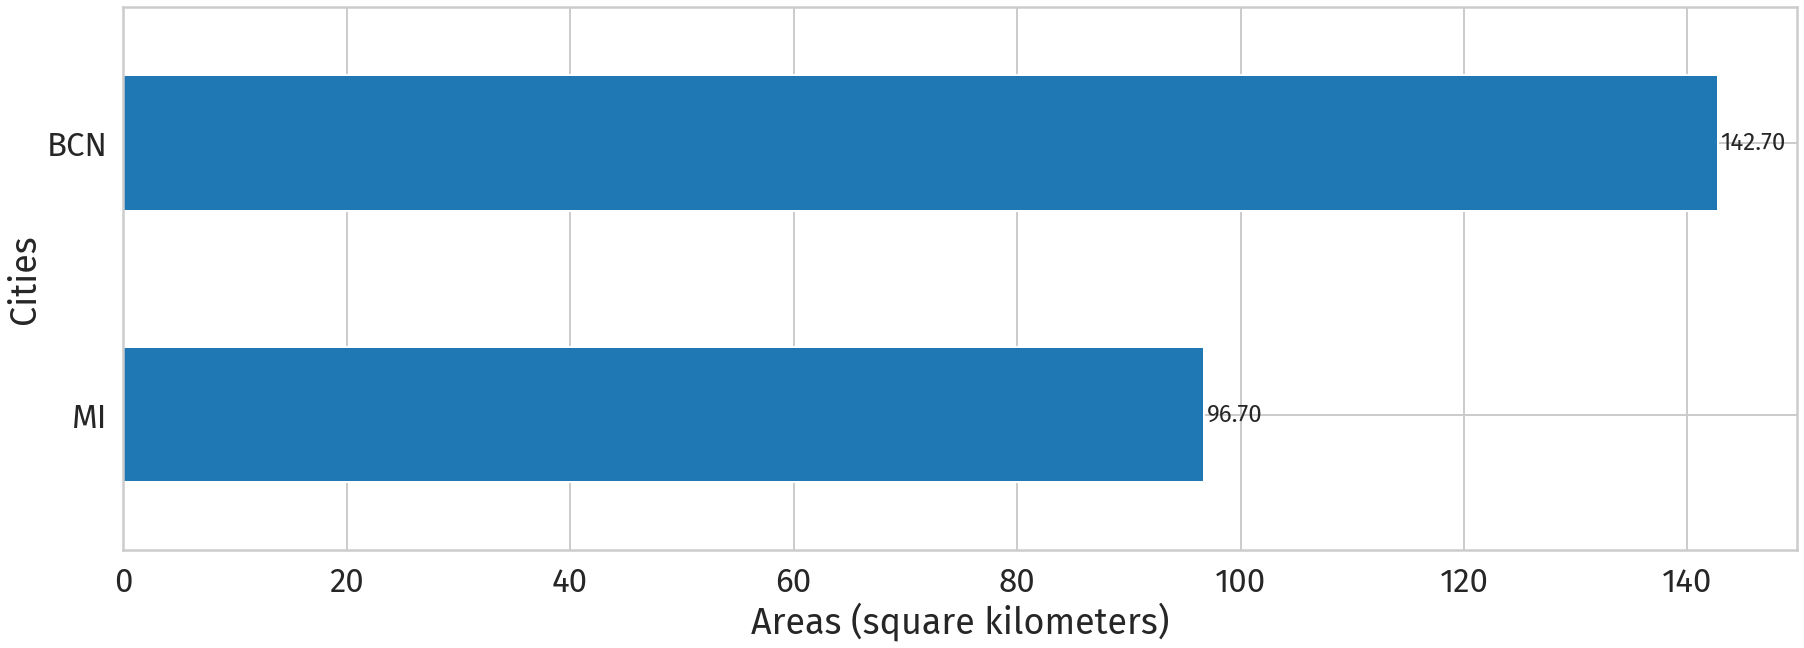

In [52]:
# Plot the data
ax = area_total_square_km.plot(kind="barh", figsize=(30,10))
ax.bar_label(ax.containers[0], fmt="%.2f", size=24, padding=3)
plt.xlabel('Areas (square kilometers)')
plt.ylabel('Cities')
plt.savefig("svg/labs_esp_ita_area_tot.svg", bbox_inches="tight")
plt.savefig("png/labs_esp_ita_area_tot.png", dpi=300, bbox_inches="tight")

## Intersections / Overlaps

### Italy

In [53]:
labs_ita_intersections = gpd.overlay(labs_ita, labs_ita, how="intersection")

In [54]:
# Number of lab areas in Italy
labs_ita.shape

(20, 18)

In [55]:
# Number of overlapping areas in Italy
labs_ita_intersections.shape

(72, 35)

In [56]:
labs_ita_intersections.head()

,name_1,longitude_1,latitude_1,total_pop_1,area_1,reachfactor_1,type_1,city_1,cluster_1,address_1,...,cluster_2,address_2,zipcode_2,Lat_2,Long_2,source_2,url_2,notes_2,geometry_y_2,geometry
0,The FabLab: Make in Milano,9.207913,45.444046,40656.0,3753146.09,0.7646,Fab Lab,Milan,MI,"Via Arcivescovo Calabiana, 6",...,MI,"Via Arcivescovo Calabiana, 6",20139.0,45.444046,9.207913,Fablabs.io,https://www.thefablab.it/,NaN,POINT (9.20791 45.44405),"POLYGON ((9.19166 45.44303, 9.19176 45.44332, ..."
1,Vectorealism FabLab,9.231811,45.438305,25520.0,2833731.26,0.5773,Service,Milan,MI,"Via Carlo Boncompagni, 57",...,MI,"Via Arcivescovo Calabiana, 6",20139.0,45.444046,9.207913,Fablabs.io,https://www.thefablab.it/,NaN,POINT (9.20791 45.44405),"POLYGON ((9.21755 45.43716, 9.21727 45.44017, ..."
2,Opendot,9.220968,45.450348,56951.0,4261112.70,0.8681,Fab Lab,Milan,MI,"Via Tertulliano, 70",...,MI,"Via Arcivescovo Calabiana, 6",20139.0,45.444046,9.207913,Fablabs.io,https://www.thefablab.it/,NaN,POINT (9.20791 45.44405),"POLYGON ((9.22092 45.44032, 9.22086 45.44035, ..."
3,The FabLab: Make in Milano,9.207913,45.444046,40656.0,3753146.09,0.7646,Fab Lab,Milan,MI,"Via Arcivescovo Calabiana, 6",...,MI,"Via Carlo Boncompagni, 57",20139.0,45.438305,9.231811,Fablabs.io,https://fablabs.io/labs/vectorealismfablab,NaN,POINT (9.23181 45.43830),"POLYGON ((9.22347 45.44377, 9.22348 45.44373, ..."
4,Vectorealism FabLab,9.231811,45.438305,25520.0,2833731.26,0.5773,Service,Milan,MI,"Via Carlo Boncompagni, 57",...,MI,"Via Carlo Boncompagni, 57",20139.0,45.438305,9.231811,Fablabs.io,https://fablabs.io/labs/vectorealismfablab,NaN,POINT (9.23181 45.43830),"POLYGON ((9.21727 45.44017, 9.21764 45.44382, ..."


In [57]:
labs_ita_intersections.explore()

In [58]:
# Overlapping areas is where name_1 and name_2 column are different, indicating which labs overlaps
labs_ita_intersections.set_index("name_1").loc["The FabLab: Make in Milano"]

,longitude_1,latitude_1,total_pop_1,area_1,reachfactor_1,type_1,city_1,cluster_1,address_1,zipcode_1,...,cluster_2,address_2,zipcode_2,Lat_2,Long_2,source_2,url_2,notes_2,geometry_y_2,geometry
name_1,,,,,,,,,,,,,,,,,,,,,
The FabLab: Make in Milano,9.207913,45.444046,40656.0,3753146.09,0.7646,Fab Lab,Milan,MI,"Via Arcivescovo Calabiana, 6",20139.0,...,MI,"Via Arcivescovo Calabiana, 6",20139.0,45.444046,9.207913,Fablabs.io,https://www.thefablab.it/,NaN,POINT (9.20791 45.44405),"POLYGON ((9.19166 45.44303, 9.19176 45.44332, ..."
The FabLab: Make in Milano,9.207913,45.444046,40656.0,3753146.09,0.7646,Fab Lab,Milan,MI,"Via Arcivescovo Calabiana, 6",20139.0,...,MI,"Via Carlo Boncompagni, 57",20139.0,45.438305,9.231811,Fablabs.io,https://fablabs.io/labs/vectorealismfablab,NaN,POINT (9.23181 45.43830),"POLYGON ((9.22347 45.44377, 9.22348 45.44373, ..."
The FabLab: Make in Milano,9.207913,45.444046,40656.0,3753146.09,0.7646,Fab Lab,Milan,MI,"Via Arcivescovo Calabiana, 6",20139.0,...,MI,"Via Tertulliano, 70",20137.0,45.450348,9.220968,Fablabs.io,https://fablabs.io/labs/opendot,NaN,POINT (9.22097 45.45035),"POLYGON ((9.20598 45.45222, 9.21078 45.45300, ..."


<AxesSubplot:>

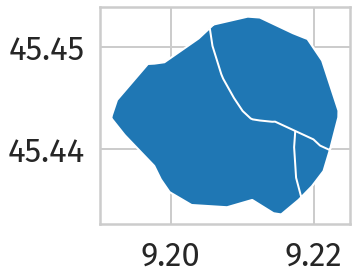

In [59]:
# The areas of one lab..
labs_ita_intersections.set_index("name_1").loc["The FabLab: Make in Milano"].plot()

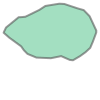

In [60]:
# Overall area
labs_ita.set_index("name").loc["The FabLab: Make in Milano"].geometry

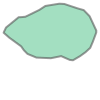

In [61]:
# Area 0
labs_ita_intersections.set_index("name_1").loc["The FabLab: Make in Milano"].iloc[0].geometry

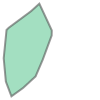

In [62]:
# Area 1
labs_ita_intersections.set_index("name_1").loc["The FabLab: Make in Milano"].iloc[1].geometry

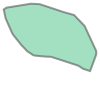

In [63]:
# Area 2
labs_ita_intersections.set_index("name_1").loc["The FabLab: Make in Milano"].iloc[2].geometry

In [64]:
# Create a dataframe with overlapping areas
overlapping_areas_ita = labs_ita_intersections.loc[~(labs_ita_intersections['name_1'] == labs_ita_intersections['name_2'])]

In [65]:
overlapping_areas_ita

,name_1,longitude_1,latitude_1,total_pop_1,area_1,reachfactor_1,type_1,city_1,cluster_1,address_1,...,cluster_2,address_2,zipcode_2,Lat_2,Long_2,source_2,url_2,notes_2,geometry_y_2,geometry
1,Vectorealism FabLab,9.231811,45.438305,25520.0,2833731.26,0.5773,Service,Milan,MI,"Via Carlo Boncompagni, 57",...,MI,"Via Arcivescovo Calabiana, 6",20139.0,45.444046,9.207913,Fablabs.io,https://www.thefablab.it/,NaN,POINT (9.20791 45.44405),"POLYGON ((9.21755 45.43716, 9.21727 45.44017, ..."
2,Opendot,9.220968,45.450348,56951.0,4261112.70,0.8681,Fab Lab,Milan,MI,"Via Tertulliano, 70",...,MI,"Via Arcivescovo Calabiana, 6",20139.0,45.444046,9.207913,Fablabs.io,https://www.thefablab.it/,NaN,POINT (9.20791 45.44405),"POLYGON ((9.22092 45.44032, 9.22086 45.44035, ..."
3,The FabLab: Make in Milano,9.207913,45.444046,40656.0,3753146.09,0.7646,Fab Lab,Milan,MI,"Via Arcivescovo Calabiana, 6",...,MI,"Via Carlo Boncompagni, 57",20139.0,45.438305,9.231811,Fablabs.io,https://fablabs.io/labs/vectorealismfablab,NaN,POINT (9.23181 45.43830),"POLYGON ((9.22347 45.44377, 9.22348 45.44373, ..."
5,Opendot,9.220968,45.450348,56951.0,4261112.70,0.8681,Fab Lab,Milan,MI,"Via Tertulliano, 70",...,MI,"Via Carlo Boncompagni, 57",20139.0,45.438305,9.231811,Fablabs.io,https://fablabs.io/labs/vectorealismfablab,NaN,POINT (9.23181 45.43830),"POLYGON ((9.22923 45.44287, 9.22855 45.44170, ..."
6,The FabLab: Make in Milano,9.207913,45.444046,40656.0,3753146.09,0.7646,Fab Lab,Milan,MI,"Via Arcivescovo Calabiana, 6",...,MI,"Via Tertulliano, 70",20137.0,45.450348,9.220968,Fablabs.io,https://fablabs.io/labs/opendot,NaN,POINT (9.22097 45.45035),"POLYGON ((9.20598 45.45222, 9.21078 45.45300, ..."
7,Vectorealism FabLab,9.231811,45.438305,25520.0,2833731.26,0.5773,Service,Milan,MI,"Via Carlo Boncompagni, 57",...,MI,"Via Tertulliano, 70",20137.0,45.450348,9.220968,Fablabs.io,https://fablabs.io/labs/opendot,NaN,POINT (9.22097 45.45035),"POLYGON ((9.21764 45.44382, 9.21792 45.44410, ..."
10,Miocugino - officina di gesta e ingegno,9.168956,45.448219,39458.0,3803092.83,0.7748,Makerspace,Milan,MI,via argelati 35,...,MI,"Corso S. Gottardo, 19",20136.0,45.452457,9.179818,Fablabs.io,https://fablabs.io/labs/DamASpaceFablab,NaN,POINT (9.17982 45.45246),"POLYGON ((9.16589 45.45665, 9.16690 45.45819, ..."
11,SuperForma,9.173072,45.457594,57463.0,4482719.37,0.9132,Service,Milan,MI,"Via Fabio Mangone, 1/A,",...,MI,"Corso S. Gottardo, 19",20136.0,45.452457,9.179818,Fablabs.io,https://fablabs.io/labs/DamASpaceFablab,NaN,POINT (9.17982 45.45246),"POLYGON ((9.18769 45.46202, 9.18790 45.45687, ..."
12,DamASpace,9.179818,45.452457,58690.0,4808370.81,0.9796,Fab Lab,Milan,MI,"Corso S. Gottardo, 19",...,MI,via argelati 35,20143.0,45.448219,9.168956,Fablabs.io,https://fablabs.io/labs/miocugino,NaN,POINT (9.16896 45.44822),"POLYGON ((9.17735 45.44186, 9.17571 45.44178, ..."
14,SuperForma,9.173072,45.457594,57463.0,4482719.37,0.9132,Service,Milan,MI,"Via Fabio Mangone, 1/A,",...,MI,via argelati 35,20143.0,45.448219,9.168956,Fablabs.io,https://fablabs.io/labs/miocugino,NaN,POINT (9.16896 45.44822),"POLYGON ((9.18070 45.44844, 9.18051 45.44844, ..."


In [66]:
overlapping_areas_ita.explore()

In [67]:
# Compare with areas
labs_ita.set_crs(epsg=4326).explore()

In [68]:
# Area of all areas.. 
overlapping_areas_ita.to_crs(epsg=3857).geometry.area

1     8.137379e+05
2     2.562447e+06
3     8.137379e+05
5     1.532238e+06
6     2.562447e+06
7     1.532238e+06
10    4.522711e+06
11    5.659421e+06
12    4.522711e+06
14    3.206976e+06
15    5.659421e+06
16    3.206976e+06
19    3.041993e+06
20    1.293144e+06
21    5.577092e+06
22    4.957400e+06
23    6.111375e+05
24    3.041993e+06
26    2.531423e+05
27    2.213855e+06
28    1.949521e+05
29    3.788776e+04
30    2.042433e+06
31    1.293144e+06
32    2.531423e+05
34    1.361911e+06
35    6.363298e+05
36    4.492617e+06
37    5.577092e+06
38    2.213855e+06
39    1.361911e+06
41    4.945350e+06
42    6.691480e+05
43    4.957400e+06
44    2.042433e+06
45    6.363298e+05
46    4.945350e+06
48    1.725696e+05
49    6.111375e+05
50    4.492617e+06
51    6.691480e+05
52    1.725696e+05
54    1.949521e+05
56    7.305057e+06
57    2.748052e+06
58    3.788776e+04
59    7.305057e+06
61    2.471576e+06
63    1.644395e+06
64    1.644395e+06
68    2.748052e+06
69    2.471576e+06
dtype: float

In [69]:
# Cumulative overlaps = individual areas served by more than 1 lab, with overlaps
overlapping_areas_ita.to_crs(epsg=3857).geometry.area.sum() / 1000000

129.9351446529525

In [70]:
# Union of overlaps = overall area that is served by more than 1 lab, union with no overlaps
overlapping_areas_ita.dissolve(by='cluster_1').to_crs(epsg=3857).geometry.area.sum() / 1000000

31.87162233838185

In [71]:
# Percentage of overlap:
overlap_total_area_ita = overlapping_areas_ita.dissolve(by='cluster_1').to_crs(epsg=3857).geometry.area.sum() / 1000000
total_area_ita = area_total_both.to_crs(epsg=3857).loc["MI"].geometry.area / 1000000
percentage_ita = overlap_total_area_ita / total_area_ita * 100
print(percentage_ita,"%")

32.9598120038453 %


### Spain

In [72]:
labs_esp_intersections = gpd.overlay(labs_esp, labs_esp, how="intersection")

In [73]:
# Number of lab areas in Spain
labs_esp.shape

(46, 18)

In [74]:
# Number of overlapping areas in Spain
labs_esp_intersections.shape

(336, 35)

In [75]:
labs_esp_intersections.head()

,name_1,longitude_1,latitude_1,total_pop_1,area_1,reachfactor_1,type_1,city_1,cluster_1,address_1,...,cluster_2,address_2,zipcode_2,Lat_2,Long_2,source_2,url_2,notes_2,geometry_y_2,geometry
0,Fab Lab Barcelona,2.194335,41.396925,90862.0,4444783.82,0.9055,Fab Lab,Barcelona,BCN,"Carrer de Pujades, 102",...,BCN,"Carrer de Pujades, 102",8005.0,41.396925,2.194335,Fablabs.io,https://fablabbcn.org/,NaN,POINT (2.19434 41.39692),"POLYGON ((2.18152 41.39531, 2.18186 41.39979, ..."
1,Danaus,2.203960,41.408007,100054.0,4821324.40,0.9822,Hackerspace,Barcelona,BCN,Av. Diagonal 114,...,BCN,"Carrer de Pujades, 102",8005.0,41.396925,2.194335,Fablabs.io,https://fablabbcn.org/,NaN,POINT (2.19434 41.39692),"POLYGON ((2.20408 41.39778, 2.20001 41.39794, ..."
2,AKASHA Hub Barcelona,2.191146,41.411054,96774.0,4579290.88,0.9329,Hackerspace,Barcelona,BCN,"carrer de la verneda, 17 loc1",...,BCN,"Carrer de Pujades, 102",8005.0,41.396925,2.194335,Fablabs.io,https://fablabbcn.org/,NaN,POINT (2.19434 41.39692),"POLYGON ((2.20331 41.40413, 2.20296 41.40292, ..."
3,Maker Convent,2.181014,41.387737,87482.0,4390605.44,0.8944,Makerspace,Barcelona,BCN,Plaça de l’Acadèmia s/n,...,BCN,"Carrer de Pujades, 102",8005.0,41.396925,2.194335,Fablabs.io,https://fablabbcn.org/,NaN,POINT (2.19434 41.39692),"POLYGON ((2.18251 41.39878, 2.18526 41.39817, ..."
4,Ateneu de Fabricació La Fàbrica del Sol,2.191718,41.382352,47179.0,2690404.47,0.5481,Ateneu de Fabricació,Barcelona,BCN,"Passeig de Salvat Papasseit, 1",...,BCN,"Carrer de Pujades, 102",8005.0,41.396925,2.194335,Fablabs.io,https://fablabbcn.org/,NaN,POINT (2.19434 41.39692),"POLYGON ((2.18438 41.38877, 2.18495 41.38876, ..."


<AxesSubplot:>

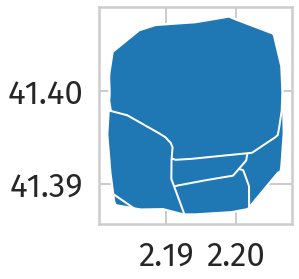

In [76]:
# The areas of one lab..
labs_esp_intersections.set_index("name_1").loc["Fab Lab Barcelona"].plot()

In [77]:
# Create a dataframe with overlapping areas
overlapping_areas_esp = labs_esp_intersections.loc[~(labs_esp_intersections['name_1'] == labs_esp_intersections['name_2'])]

In [78]:
overlapping_areas_esp.explore()

In [79]:
labs_esp_intersections.explore()

In [80]:
# Compare with areas
labs_esp.set_crs(epsg=4326).explore()

In [81]:
# Area of all areas.. 
overlapping_areas_esp.to_crs(epsg=3857).geometry.area

1      2.439927e+06
2      2.234392e+06
3      1.780851e+06
4      1.334917e+06
5      1.671944e+06
           ...     
324    6.845688e+04
326    7.269055e+05
327    4.001618e+06
331    5.199148e+05
332    5.199148e+05
Length: 290, dtype: float64

In [82]:
# Cumulative overlaps = individual areas served by more than 1 lab, with overlaps
overlapping_areas_esp.to_crs(epsg=3857).geometry.area.sum() / 1000000

599.8863094896335

In [83]:
# Union of overlaps = overall area that is served by more than 1 lab, union with no overlaps
overlapping_areas_esp.dissolve(by='cluster_1').to_crs(epsg=3857).geometry.area.sum() / 1000000

71.48276895972057

In [84]:
# Percentage of overlap:
overlap_total_area_esp = overlapping_areas_esp.dissolve(by='cluster_1').to_crs(epsg=3857).geometry.area.sum() / 1000000
total_area_esp = area_total_both.to_crs(epsg=3857).loc["BCN"].geometry.area / 1000000
percentage_esp = overlap_total_area_esp / total_area_esp * 100
print(percentage_esp,"%")

50.09437620287818 %


In [85]:
# Data for plotting
areas_plot = pd.DataFrame(columns = ["City", "Total area reached", "Overlapping area"])

In [86]:
areas_plot = areas_plot.append({'City':'BCN', 'Total area reached':total_area_esp, 'Overlapping area': overlap_total_area_esp}, ignore_index=True)

In [87]:
areas_plot = areas_plot.append({'City':'MI', 'Total area reached':total_area_ita, 'Overlapping area': overlap_total_area_ita}, ignore_index=True)

In [88]:
areas_plot.set_index("City", inplace=True)

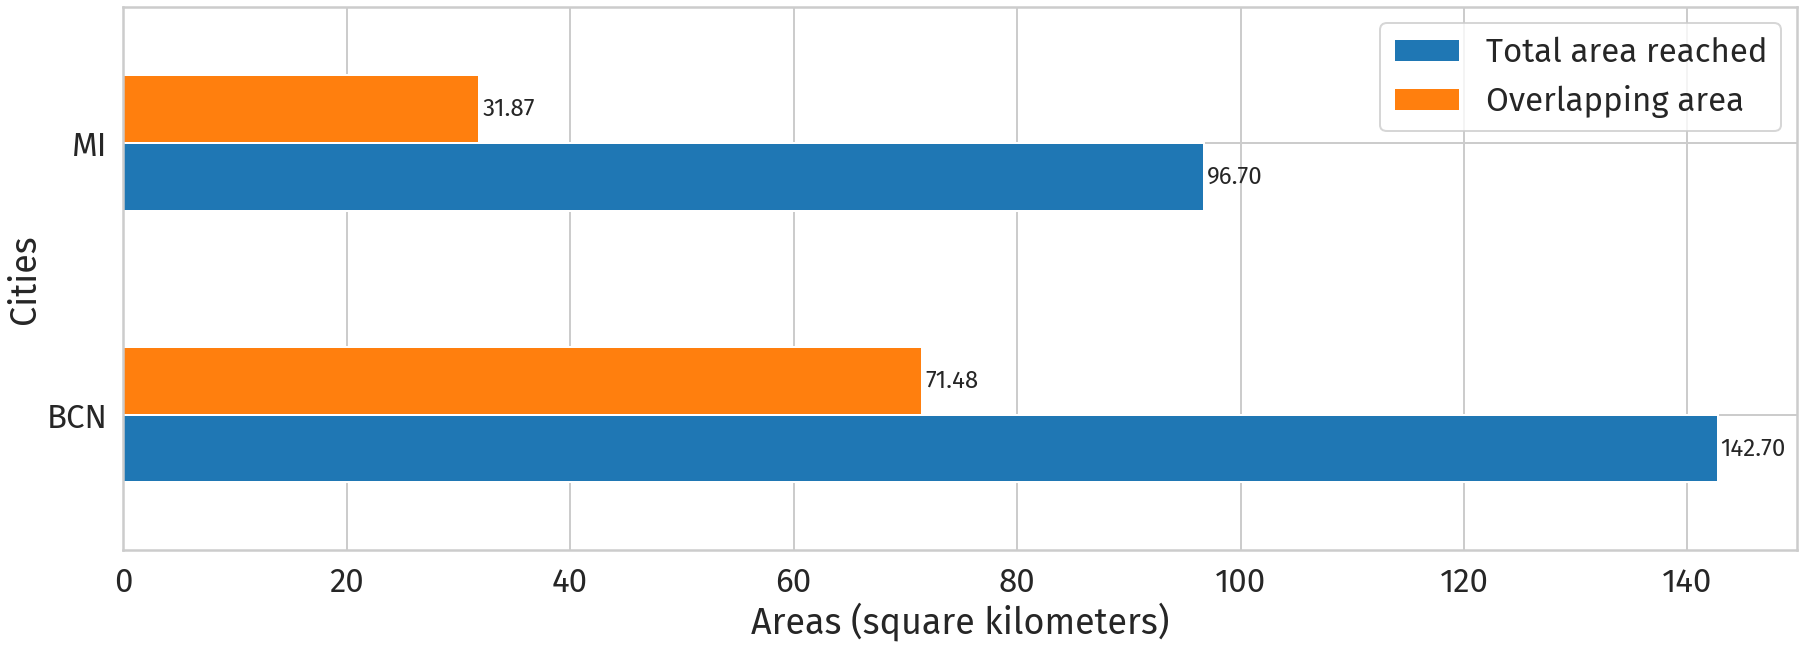

In [89]:
# Plot the data
ax = areas_plot.plot(kind="barh", figsize=(30,10))
ax.bar_label(ax.containers[0], fmt="%.2f", size=24, padding=3)
ax.bar_label(ax.containers[1], fmt="%.2f", size=24, padding=3)
plt.xlabel('Areas (square kilometers)')
plt.ylabel('Cities')
plt.savefig("svg/labs_esp_ita_area_tot_overlaps.svg", bbox_inches="tight")
plt.savefig("png/labs_esp_ita_area_tot_overlaps.png", dpi=300, bbox_inches="tight")

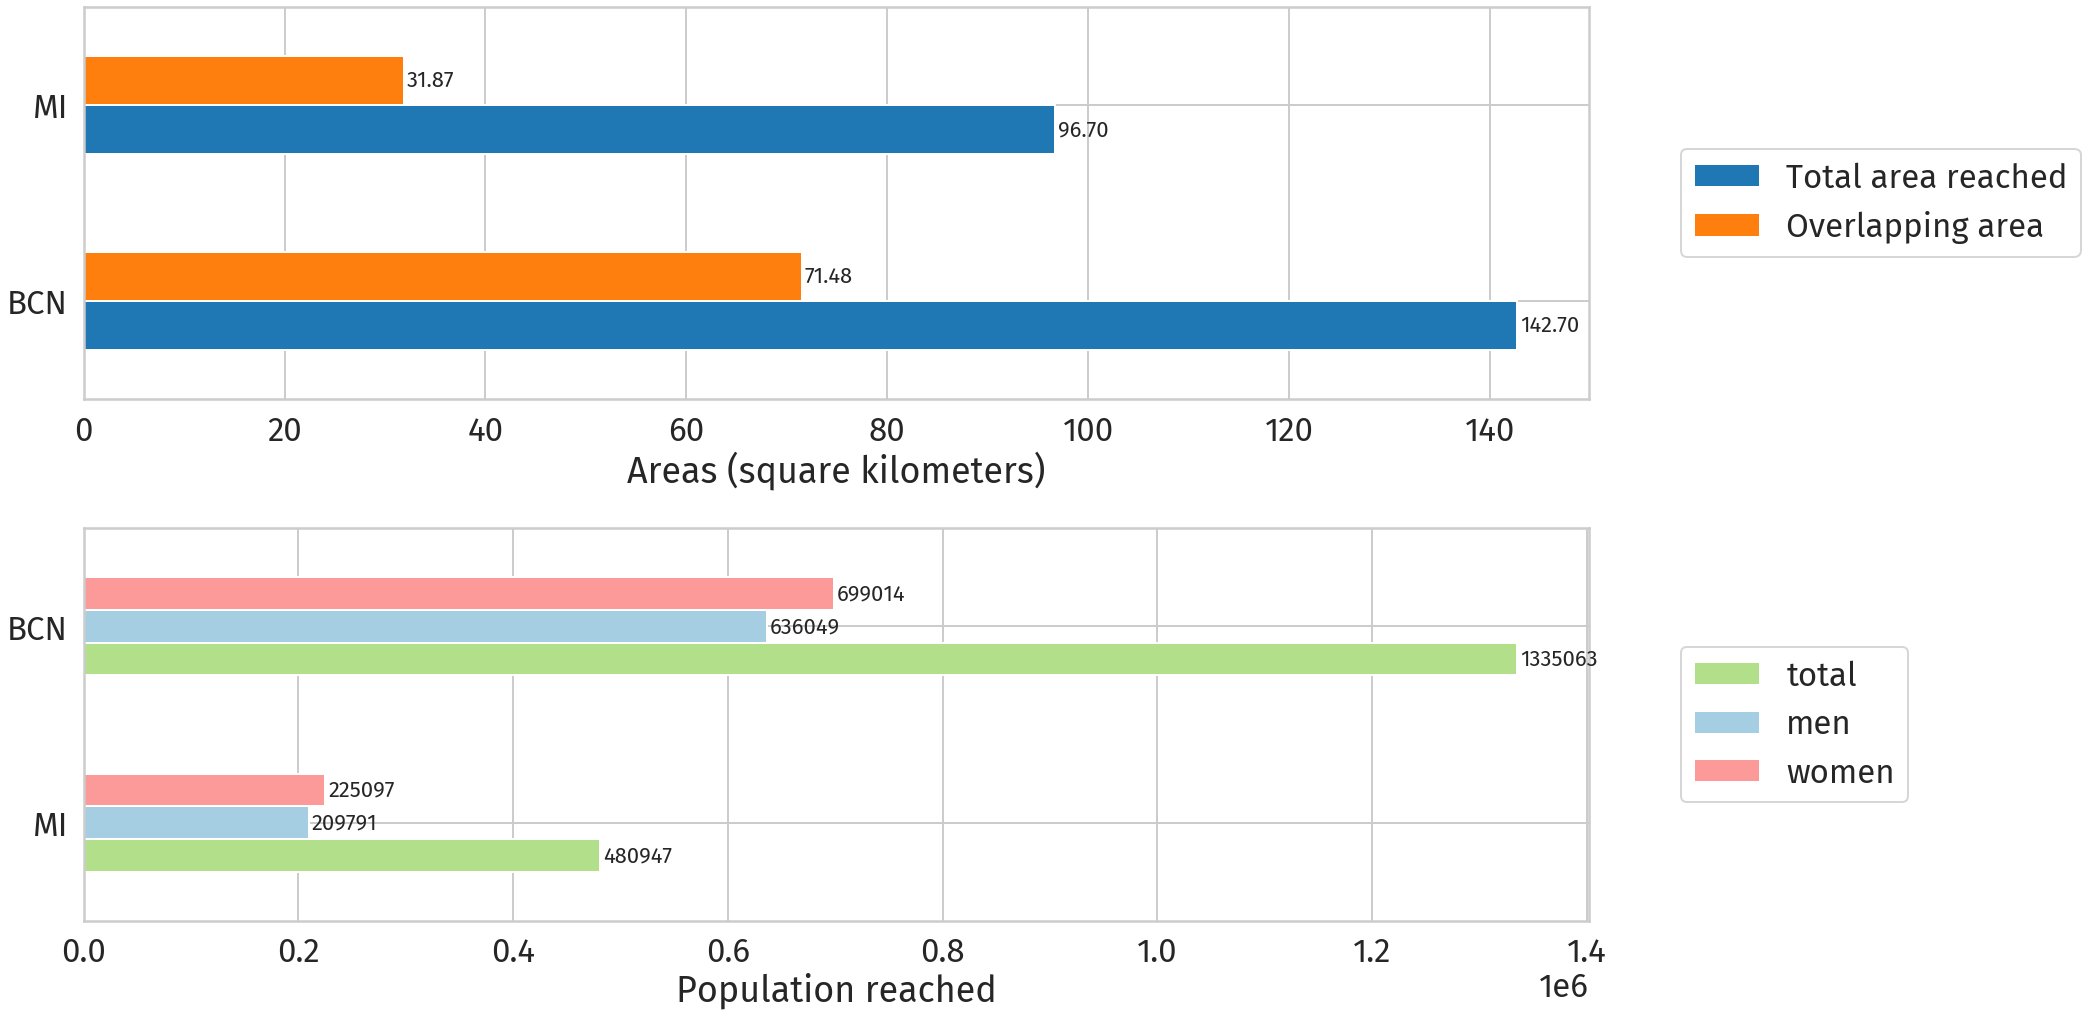

In [90]:
## Two plots together
figure, axes = plt.subplots(2, 1, figsize=(30,15))
areas_plot.plot(ax=axes[0], kind="barh")
axes[0].bar_label(axes[0].containers[0], fmt="%.2f", size=22, padding=3)
axes[0].bar_label(axes[0].containers[1], fmt="%.2f", size=22, padding=3)
axes[0].set_xlabel('Areas (square kilometers)')
axes[0].set_ylabel('')

colors = [sns.color_palette("Paired")[2],sns.color_palette("Paired")[0],sns.color_palette("Paired")[4]]
area_total_both[["total", "men", "women"]].plot(ax=axes[1], kind="barh", color=colors)
axes[1].bar_label(axes[1].containers[0], fmt="%d", size=22, padding=3)
axes[1].bar_label(axes[1].containers[1], fmt="%d", size=22, padding=3)
axes[1].bar_label(axes[1].containers[2], fmt="%d", size=22, padding=3)
axes[1].set_xlabel('Population reached')
axes[1].set_ylabel('')

axes[0].legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
axes[1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5))


#axes[0].title.set_text('Area')
#axes[1].title.set_text('Population')

plt.tight_layout()
plt.savefig("png/labs_esp_ita_area_pop_subplot.png", dpi=300, bbox_inches='tight')
plt.savefig("svg/labs_esp_ita_area_pop_subplot.svg", bbox_inches='tight')